# Poisson problem (1D/2D)

In [1]:
from cuqi.problem import BayesianProblem
from cuqi.distribution import Gaussian
from cuqipy_fenics.utilities import ExpressionFromCallable
from cuqipy_fenics.testproblem import FEniCSPoisson2D, FEniCSDiffusion1D
from cuqi.experimental.mcmc import MH, NUTS, MALA, ULA 
import numpy as np
import cuqi
import cuqipy_fenics
import dolfin as dl
import matplotlib.pyplot as plt
# import check_grad
from scipy.optimize import check_grad
from cuqi.utilities import approx_gradient

# set logging level of dl
dl.set_log_level(dl.LogLevel.ERROR)

Print CUQIpy and CUQIpy-FEniCS versions:

In [2]:
print(cuqi.__version__)
print(cuqipy_fenics.__version__)
print(cuqipy_fenics.__file__)

0+untagged.3470.g36baffb
0+untagged.256.g7d0d1eb
/Users/amal/Documents/research_code/CUQI-DTU/CUQIpy-FEniCS/cuqipy_fenics/__init__.py


In [3]:
physical_dim = 1 # choice of physical dimension
model_type = 'diffusion'  #'convolution' #'convolution' #'diffusion' # 'identity' # choice of model type
prior_type = 'TV'#'Gaussian' #'TV' #'Gaussian' # 'TV'
enable_FD = False
#sampler_choice = "NUTS" #"MALA" #"NUTS"


In [48]:
# parameter set up
if model_type == 'convolution':
    np.random.seed(0)
    sampler_choice = "NUTS"
    TV_weight = 1.0e2
    TV_beta = 1e-4
    plot_par = False
    Ns = 1
    Nb = 500
    max_depth = 5
    step_size = None
    remove_burnin = 0
    apply_grid_search=False
    # initial point was zero

if model_type == 'diffusion':
    np.random.seed(0)
    sampler_choice = "NUTS"
    TV_weight = 80 #40 #60
    TV_beta = 1e-7
    plot_par = True
    Ns = 1000
    Nb = 20000
    max_depth = 3
    step_size = 0.1
    remove_burnin = 15000
    apply_grid_search=False


    

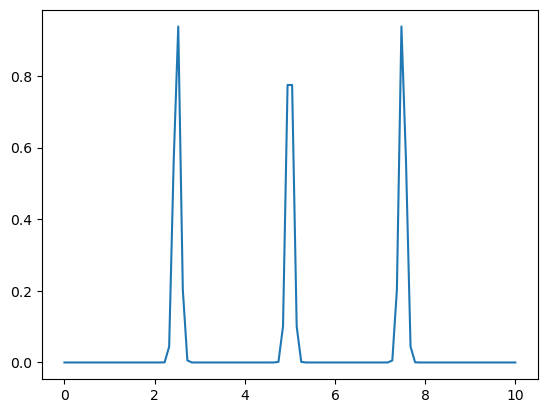

In [5]:
endpoint = 10 # domain length
# f is sum of 3 exponentials at 1/4*endpoint and 1/2*endpoint and 3/4*endpoint

def f(x):
    return np.exp(-100*(x-1/4*endpoint)**2) + np.exp(-100*(x-1/2*endpoint)**2) + np.exp(-100*(x-3/4*endpoint)**2)

#plot f
x = np.linspace(0, endpoint, 100)
plt.plot(x, f(x))


f_expr = ExpressionFromCallable(f)

In [6]:
if model_type == 'diffusion':
    if physical_dim == 2:
        A = FEniCSPoisson2D(dim=(16,16), field_type=None, mapping='exponential', bc_types=['Dirichlet', 'Neumann', 'Dirichlet', 'Neumann']).model
    elif physical_dim == 1:

        A = FEniCSDiffusion1D(dim=40, right_bc=0, f=f_expr, endpoint=endpoint).model # note source term is zero for the 1D case
elif model_type == 'identity':
    domain_dim = 41
    A = cuqi.model.LinearModel(np.eye(domain_dim))

elif model_type == 'convolution':
    domain_dim = 40
    A = cuqi.testproblem.Deconvolution1D(dim=domain_dim, PSF_param=2, PSF_size=40).model

In [7]:
G_domain = A.domain_geometry
G_range = A.range_geometry

In [8]:
A


CUQI PDEModel: FEniCSContinuous(41,) -> FEniCSContinuous(41,).
    Forward parameters: ['x'].
    PDE: SteadyStateLinearFEniCSPDE.

In [9]:
# SMPrior class
class SMPrior:
    def __init__(self, ginv, corrlength, var, mean, covariancetype=None):
        self.corrlength = corrlength
        self.mean = mean
        self.c = 1e-9  # default value
        if covariancetype is not None:
            self.covariancetype = covariancetype
        else:
            self.covariancetype = 'Squared Distance'  # default
        self.compute_L(ginv, corrlength, var)

    def compute_L(self, g, corrlength, var):
        ng = g.shape[0]
        a = var - self.c
        b = np.sqrt(-corrlength**2 / (2 * np.log(0.01)))
        Gamma_pr = np.zeros((ng, ng))

        for ii in range(ng):
            for jj in range(ii, ng):
                dist_ij = np.linalg.norm(g[ii, :] - g[jj, :])
                if self.covariancetype == 'Squared Distance':
                    gamma_ij = a * np.exp(-dist_ij**2 / (2 * b**2))
                elif self.covariancetype == 'Ornstein-Uhlenbeck':
                    gamma_ij = a * np.exp(-dist_ij / corrlength)
                else:
                    raise ValueError('Unrecognized prior covariance type')
                if ii == jj:
                    gamma_ij = gamma_ij + self.c
                Gamma_pr[ii, jj] = gamma_ij
                Gamma_pr[jj, ii] = gamma_ij
        
        self.cov = Gamma_pr
        self.L = np.linalg.cholesky(np.linalg.inv(Gamma_pr)).T

    def draw_samples(self, nsamples):
        samples = self.mean + np.linalg.solve(self.L, np.random.randn(self.L.shape[0], nsamples))
        return samples

    def eval_fun(self, args):
        sigma = args[0]
        res = 0.5 * np.linalg.norm(self.L @ (sigma - self.mean))**2
        return res
    
    def evaluate_target_external(self, x, compute_grad=False):
        x = x.reshape((-1,1))
        # print("x.shape: ", x.shape)
        # print("self.mean.shape: ", self.mean.shape)
        if compute_grad:
            grad = self.L.T @ self.L @ (x - self.mean)
        else:
            grad = None
        
        return self.eval_fun(x), grad
        

    def compute_hess_and_grad(self, args, nparam):
        sigma = args[0]
        Hess = self.L.T @ self.L
        grad = Hess @ (sigma - self.mean)

        if nparam > len(sigma):
            Hess = np.block([[Hess, np.zeros((len(sigma), nparam - len(sigma)))],
                             [np.zeros((nparam - len(sigma), len(sigma))), np.zeros((nparam - len(sigma), nparam - len(sigma)))]])
            grad = np.concatenate([grad, np.zeros(nparam - len(sigma))])


        return Hess, grad

In [10]:
#class MyTV:
#    def __init__(self, q0fun, mesh, delta,**kwargs):
#        #self.qfun = project(qFunction(phi,q1,q2),V1)
#
#        self.V1 = FunctionSpace(mesh,'CG',1)
#        self.V02 = VectorFunctionSpace(mesh,'DG',0)
#
#        self.q0fun = q0fun
#        self.q0grad = project(grad(self.q0fun),self.V02)
#        self.q0_denom = Denom(self.q0grad,delta)
#
#        # operator
#        self.p_trial = TrialFunction(self.V1)
#        self.p_test = TestFunction(self.V1)
#
#        #self.L_op = assemble(ufl.inner(self.p_trial, self.p_test)*dx)
#        #self.TV_op = assemble(self.q_denom*ufl.inner(grad(self.p_trial),grad(self.p_test))*dx)
#        self.TV_op = assemble((self.q0_denom*inner(grad(self.p_trial),grad(self.p_test)))*dx)
#
#        self.delta = delta
#
#    def eval_TV(self,qfun):
#        self.update_op(qfun)
#        return np.dot(self.TV_op * qfun.vector(),qfun.vector())
#
#    def eval_grad(self,qfun):
#        self.update_op(qfun)
#        return 2*(self.TV_op * qfun.vector())#[idx2]
#    
#    def update_op(self,q0fun):
#        self.q0fun = q0fun
#        self.q0grad = project(grad(self.q0fun),self.V02)
#        self.q0_denom = Denom(self.q0grad,self.delta)
#        self.TV_op = assemble((self.q0_denom*inner(grad(self.p_trial),grad(self.p_test)))*dx) 
#

class TV_reg:
    def __init__(self, V, beta, weight):
        self.beta    = dl.Constant(beta)
        self.m_tilde  = dl.TestFunction(V)
        self.m_hat = dl.TrialFunction(V)
        self.weight = weight
        
    def cost_reg(self, m):
        return -self.weight*dl.assemble(dl.sqrt( dl.inner(dl.grad(m), dl.grad(m)) + self.beta)*dl.dx)

    
    def grad_reg(self, m):  
        #print("grad", dl.grad)      
        TVm = dl.sqrt( dl.inner(dl.grad(m), dl.grad(m)) + self.beta)
        self.TVm = TVm
        grad_val = dl.assemble(dl.Constant(1.)/TVm*dl.inner(dl.grad(m), dl.grad(self.m_tilde))*dl.dx)
        return -self.weight*grad_val
    
    def eval_density(self, x):
        # convert from numpy array to dolfin function
        x_fun = dl.Function(H)
        x_fun.vector()[:] = x
        return self.cost_reg(x_fun)
    
    def eval_grad_density(self, x):
        # convert from numpy array to dolfin function
        x_fun = dl.Function(H)
        x_fun.vector()[:] = x
        grad_val = self.grad_reg(x_fun).get_local()
        return grad_val

In [11]:
if model_type == 'diffusion':
    H = G_domain.function_space
    mesh = H.mesh()
elif model_type == 'identity' or model_type == 'convolution':
    mesh = dl.UnitIntervalMesh(domain_dim-1)
    H = dl.FunctionSpace(mesh, 'CG', 1)

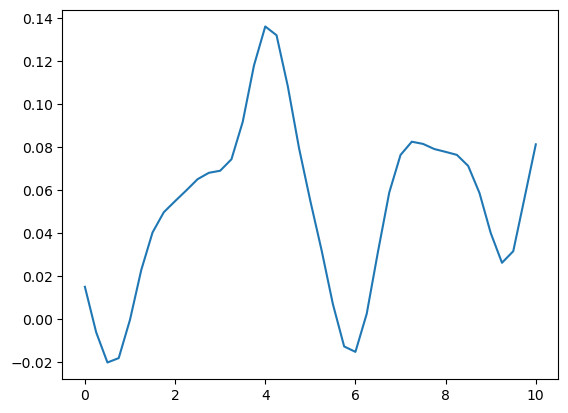

In [12]:

# Create correlation matrix for prior x
v2d = dl.vertex_to_dof_map(H)
d2v = dl.dof_to_vertex_map(H)

mean_sigma = np.zeros((H.dim(), 1)) #linearization point
corrlength =  0.2* endpoint
var_sigma = 0.05 ** 2   #prior variance

smprior = SMPrior(mesh.coordinates()[d2v], corrlength, var_sigma, mean_sigma)#, covariancetype='Ornstein-Uhlenbeck')


sample = smprior.draw_samples(1)
fun = dl.Function(H)
fun.vector().set_local(sample)

im = dl.plot(fun)
if physical_dim == 2:
    plt.colorbar(im)


In [13]:
tv_reg = TV_reg(H, beta=TV_beta, weight=TV_weight)




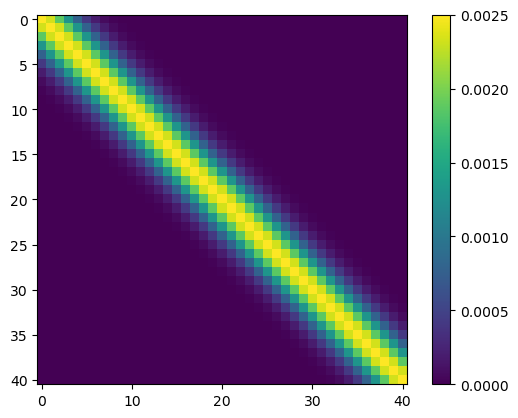

In [14]:
# visualize the covariance matrix 
plt.figure()
im = plt.imshow(smprior.cov)
plt.colorbar(im)

In [15]:
if prior_type == 'Gaussian':
    cov_const = 1 #100
    x = Gaussian(np.zeros(G_domain.par_dim), cov=cov_const*smprior.cov, geometry=G_domain)
elif prior_type == 'TV':
    # CUQIpy user defined distribution
    x = cuqi.distribution.UserDefinedDistribution(logpdf_func=tv_reg.eval_density,
                                              gradient_func=tv_reg.eval_grad_density,
                                              dim=H.dim())

In [16]:
x

CUQI UserDefinedDistribution.

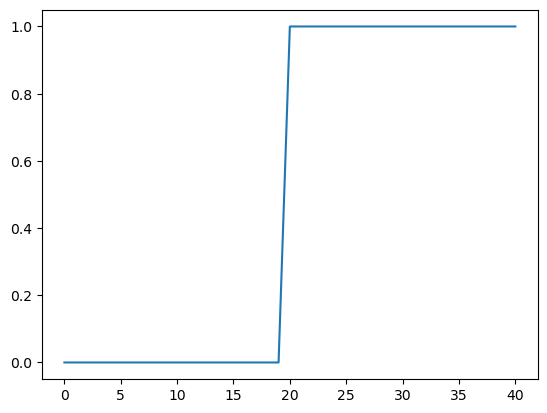

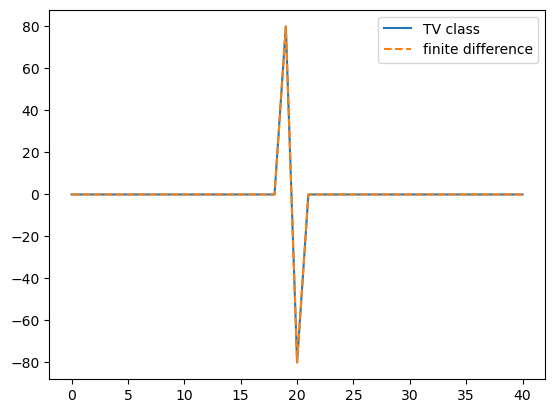

In [17]:
# x_1 = np.random.randn(G_domain.par_dim)
# x_1 step function
x_1 = np.zeros(G_domain.par_dim)
x_1[G_domain.par_dim//2:] = 1
x_1_cuqiarray = cuqi.array.CUQIarray(x_1)
x_1_cuqiarray.plot()
plt.figure()
# verify the TV gradient computation
plt.plot(x.gradient(x_1))
# plot finite difference gradient 

plt.plot(approx_gradient(x.logd, x_1, 1e-12), '--')
plt.legend(['TV class', 'finite difference'])

Sample: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s, acc rate: 0.00%]
/Users/amal/opt/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/amal/opt/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/amal/opt/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


Selecting 5 randomly chosen variables


/Users/amal/opt/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/amal/opt/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<AxesSubplot: title={'center': 'v24'}>,
        <AxesSubplot: title={'center': 'v24'}>],
       [<AxesSubplot: title={'center': 'v30'}>,
        <AxesSubplot: title={'center': 'v30'}>],
       [<AxesSubplot: title={'center': 'v35'}>,
        <AxesSubplot: title={'center': 'v35'}>],
       [<AxesSubplot: title={'center': 'v6'}>,
        <AxesSubplot: title={'center': 'v6'}>],
       [<AxesSubplot: title={'center': 'v8'}>,
        <AxesSubplot: title={'center': 'v8'}>]], dtype=object)

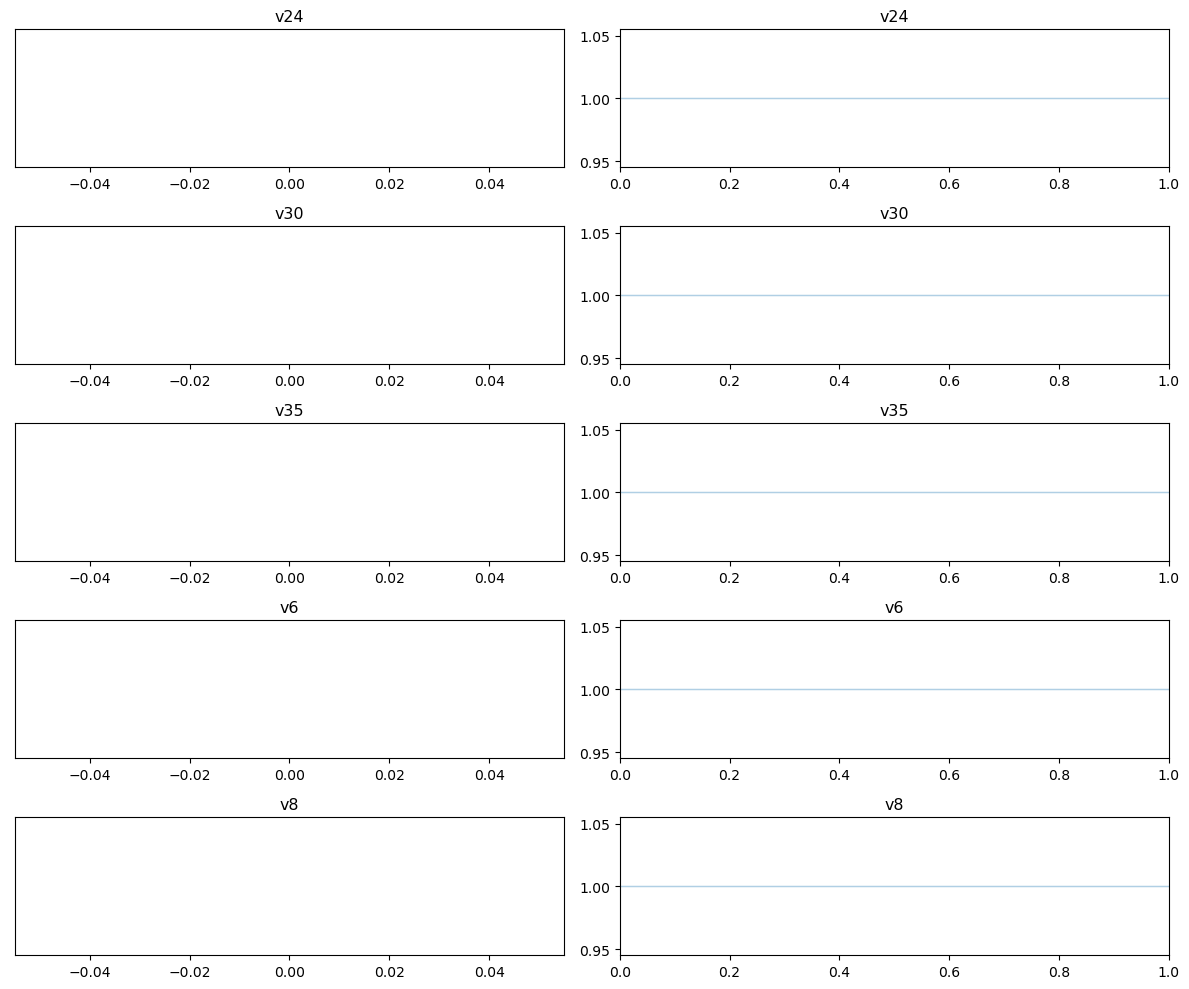

In [18]:
# sample the prior 
Ns_prior = 1
if prior_type == 'Gaussian':
    x_samples = x.sample(Ns_prior)

elif prior_type == 'TV':
    prior_sampler = NUTS(x, max_depth=5)
    prior_sampler.warmup(1)
    prior_sampler.sample(Ns_prior)
    x_samples = prior_sampler.get_samples()

#x_samples.plot()

x_samples.plot_trace()




arviz - WARNING - Shape validation failed: input_shape: (1, 2), minimum_shape: (chains=1, draws=4)


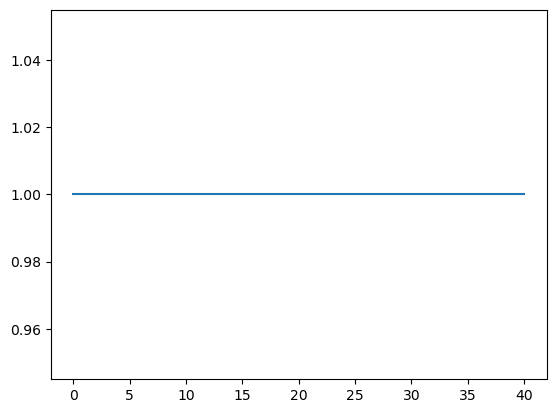

In [19]:
x_samples.compute_ess()
#x_samples.burnthin(5).plot_ci()
plt.figure()
x_samples.plot([-1])

In [20]:
# Set the random seed
np.random.seed(3) 

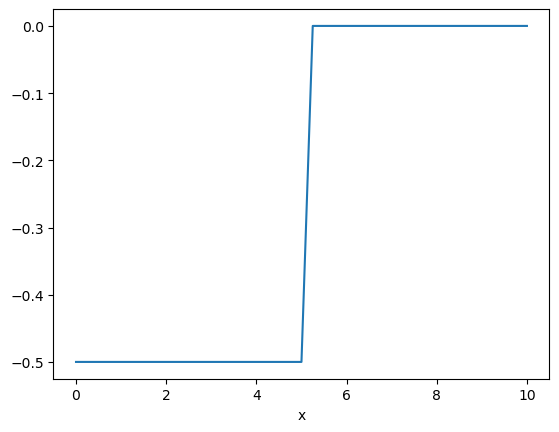

In [21]:
if model_type == 'diffusion':
    if prior_type == 'Gaussian':
        x_true = x.sample()
    elif prior_type == 'TV':
        fun_x_true_expr = dl.Expression('x[0] > 5 ? 0 : -0.5', degree=1)
        x_true_fun = dl.interpolate(fun_x_true_expr, H)
        x_true = cuqi.array.CUQIarray(x_true_fun.vector().get_local(), geometry=G_domain)
        
    else:
        raise ValueError('Unrecognized prior type')
    
elif model_type == 'identity' or model_type == 'convolution':
    x_true = cuqi.array.CUQIarray(np.zeros(G_domain.par_dim), geometry=G_domain)
    x_true[G_domain.par_dim//2:] = 1 + np.random.randn(G_domain.par_dim//2)*0.1



im = x_true.plot()
if physical_dim == 2:
    plt.colorbar(im[0])



This cell to compute s_noise

In [22]:
noise_level = 0.01
x_true.shape
y_true = A(x_true)
s_noise = 1.0/np.sqrt(G_domain.par_dim)* noise_level*np.linalg.norm(y_true)

In [23]:
y = Gaussian(A(x), s_noise**2, geometry=G_range)

[[<matplotlib.lines.Line2D at 0x1a1f97d00>]]

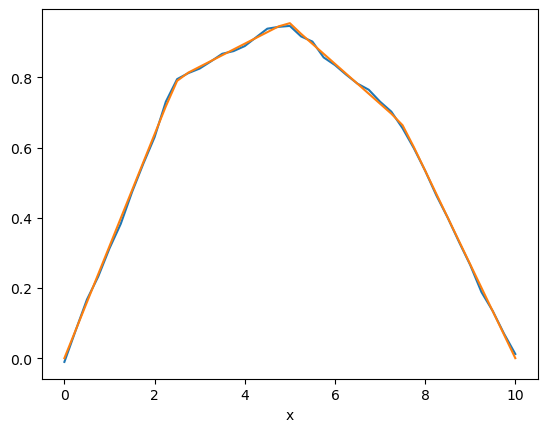

In [24]:
y_obs = y(x=x_true).sample()
y_obs.plot()
y_true.plot()

In [25]:
BP = BayesianProblem(y, x).set_data(y=y_obs)

x.logd(x_1) -80.24665790749299
BP.likelihood.logd(x_1) [-64367.48729987]
x.logd(x_2) -4299.061072781341
BP.likelihood.logd(x_2) [-6822.40122188]


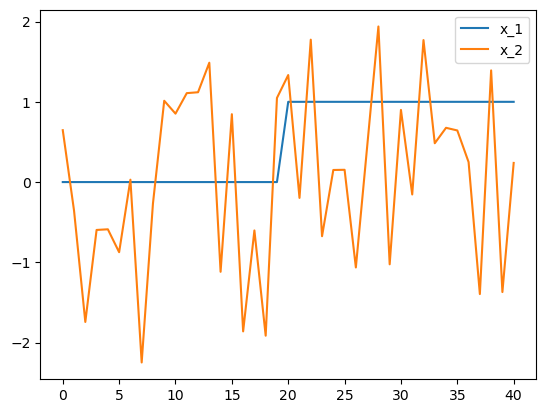

In [26]:
plt.plot(x_1, label='x_1')

x_2 = np.random.randn(G_domain.par_dim)
plt.plot(x_2, label='x_2')
plt.legend()
#print(x.logd(x_1))
#print(x.logd(x_1*0+1))
#print(x.logd(np.random.randn(G_domain.par_dim)))

# at x_1 , logd for prior and for likelihood
print('x.logd(x_1)', x.logd(x_1))
print('BP.likelihood.logd(x_1)', BP.likelihood.logd(x_1))

# at x_2 , logd for prior and for likelihood
print('x.logd(x_2)', x.logd(x_2))
print('BP.likelihood.logd(x_2)', BP.likelihood.logd(x_2))

In [27]:
# map point
if enable_FD:
    BP.posterior.enable_FD() 
else:
    BP.posterior.disable_FD()
map_x = BP.MAP()


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic solver selection is a work-in-progress !!!
!!!      Always validate the computed results.       !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Optimizing with exact gradients
Using scipy.optimize.minimize on negative log of Posterior
x0: ones vector


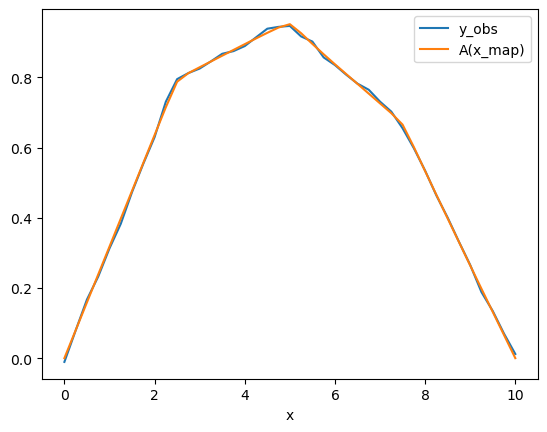

In [28]:
# plot map predicted data

y_obs.plot(label='y_obs')
A(map_x).plot(label='A(x_map)')
plt.legend()


(-1.0, 0.7)

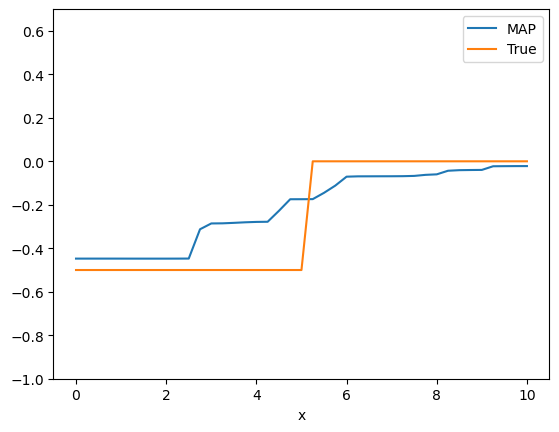

In [29]:
map_x.plot()
x_true.plot()
plt.legend(['MAP', 'True'])
plt.ylim(-1.0, 0.7)

In [30]:
if apply_grid_search:
    # grid search for computing the map
    grid_weights = [40, 50, 60]
    grid_beta = [1e-6, 1e-7, 1e-8, 1e-9] #1e-3, 1e-4, 
    map_list = []
    weight_list = []
    beta_list = []
    TV_m_list = []
    
    for i, weight in enumerate(grid_weights):
        for j, beta in enumerate(grid_beta):
            print('iteration number {} of total {}'.format(i*len(grid_beta) + j, len(grid_weights)*len(grid_beta)))
            print('weight: ', weight)
            print('beta: ', beta)
            TV_reg_i = TV_reg(H, beta=beta, weight=weight)
            # define x
            x = cuqi.distribution.UserDefinedDistribution(logpdf_func=TV_reg_i.eval_density,
                                                        gradient_func=TV_reg_i.eval_grad_density,
                                                        dim=H.dim())
            BP_i = BayesianProblem(y, x).set_data(y=y_obs)
            BP_i.posterior.disable_FD()
            map_x = BP_i.MAP()
            TV_m_list.append(TV_reg_i.TVm)
            map_list.append(map_x)
            weight_list.append(weight)
            beta_list.append(beta)
    
    
    

In [31]:
if apply_grid_search:
    # plot all map points with labels
    style = ['-', '--', '-.', ':']*3
    starting_idx = 0
    for i, map_x in enumerate(map_list[starting_idx:12]):
        map_x.plot(label='weight: '+str(weight_list[starting_idx+i])+' beta: '+str(beta_list[starting_idx+i]) + ' TVm: '+str(dl.assemble(TV_m_list[starting_idx+i]*dl.dx)), linestyle=style[i])
    
    x_true.plot(label='True', color='black')
    plt.ylim(-0.52, 0.1)
    # plot legend and put it outside the plot
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [32]:
#posterior_samples = BP.UQ(Ns=3000, Nb=2, percent=97)
posterior = BP.posterior()
#sampler = cuqi.sampler.NUTS(posterior, max_depth=4, x0=np.zeros(G_domain.par_dim)+.001)
#sampler = cuqi.sampler.ULA(posterior, x0=np.zeros(G_domain.par_dim)+.001, scale=0.00000005)
# np.zeros(G_domain.par_dim)+.001

#initial_point = np.zeros(G_domain.par_dim) # x_true.to_numpy()
#initial_point = 0.5*map_x.to_numpy()
initial_point = map_x.to_numpy()
#initial_point = np.ones(G_domain.par_dim)*-0.25

#sampler = cuqi.experimental.mcmc.PCN(posterior, initial_point=initial_point, scale=0.05)#, max_depth=10, scale=0.005)

if sampler_choice == "NUTS":
    sampler = cuqi.experimental.mcmc.NUTS(posterior,
                                          initial_point=initial_point,
                                          max_depth=max_depth,
                                          step_size=step_size)

elif sampler_choice == "MALA":
    sampler = cuqi.experimental.mcmc.MALA(posterior, initial_point=initial_point, scale=2.1e-7)
    Ns = 1000
    Nb = 20

elif sampler_choice == "ULA":
    sampler = cuqi.experimental.mcmc.ULA(posterior, initial_point=initial_point, scale=2.1e-7)
    Ns = 100
    Nb = 20

elif sampler_choice == "MH":
    sampler = cuqi.experimental.mcmc.MH(posterior, initial_point=initial_point, scale=2.1e-5)
    Ns = 1000
    Nb = 20


_ = sampler.warmup(Nb)
_ = sampler.sample(Ns)


#posterior_samples = sampler.sample_adapt(100, Nb=10)

Sample: 100%|██████████| 1000/1000 [06:46<00:00,  2.46it/s, acc rate: 100.00%]


In [49]:

posterior_samples = sampler.get_samples().burnthin(remove_burnin)

In [50]:
try:
    print(sampler.scale)
except:
    pass

/Users/amal/opt/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/Users/amal/opt/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0.33591098]


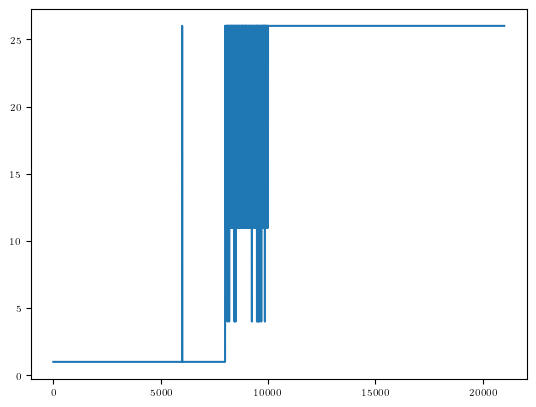

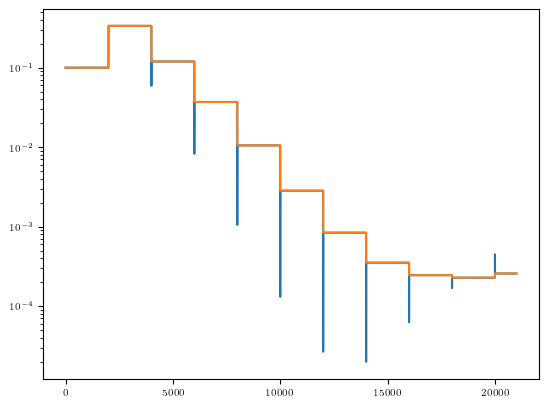

In [51]:
try:
    plt.plot(sampler.num_tree_node_list)
    plt.figure()
    plt.semilogy(sampler.epsilon_list)
    plt.semilogy(sampler.epsilon_bar_list)
    print(np.max(sampler.epsilon_list))
except:
    pass

In [52]:
2**7

128

In [53]:
# sampler.scale

Code cell for generating Figure 1

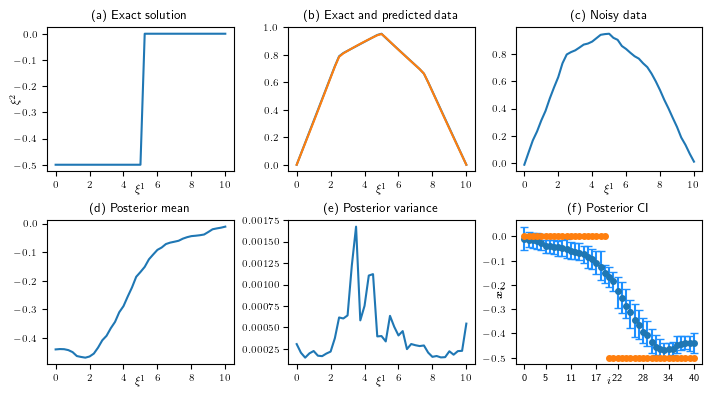

In [54]:

if model_type == 'diffusion':

    import os
    from matplotlib import ticker
    import matplotlib.pyplot as plt
    
    # Set up matplotlib
    SMALL_SIZE = 7
    MEDIUM_SIZE = 8
    BIGGER_SIZE = 9
    plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    # Use latex package
    plt.rc('text', usetex=True)
    plt.rc('text.latex', preamble=r'\usepackage{bm}')
    
    # Data directory
    fig_dir = './figs/'
    
    # Figure file
    fig_dir = fig_dir 
    
    # Check if the directory exists
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    
    # Figure version
    version = 'v8'
    
    # Figure file
    fig_file = fig_dir + 'paper_figure1_'+version+'.pdf'
    
    # Create the figure
    cm_to_in = 1/2.54
    fig, axs = plt.subplots(nrows=2, ncols=3,
                            figsize=(17.8*cm_to_in, 9.8*cm_to_in),
                            layout="constrained")
    
    # Define the colors to be used in the plots
    colors = ['C0', 'green', 'purple', 'k', 'gray']
    
    # (a)
    plt.sca(axs[0,0])
    im = x_true.plot(subplots=False)#, vmin=-0.2, vmax=0.5, mode='color')
    
    if physical_dim == 2: 
        inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
        fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
        plt.gca().set_ylim(0, 1)
    
    #plt.gca().set_xlim(0, 1)
    plt.gca().set_title('(a) Exact solution')
    plt.ylabel('$\\xi^2$')
    plt.gca().yaxis.labelpad = -5
    plt.xlabel('$\\xi^1$')
    plt.gca().xaxis.labelpad = -5
    
    # (b)
    plt.sca(axs[0,1])
    im = y_true.plot(subplots=False)
    
    if physical_dim == 2:
        inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
        fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
        plt.ylabel('$\\xi^2$')
        plt.gca().yaxis.labelpad = -5
        plt.gca().set_title('(b) Exact data')
    else:
        samples_mean = cuqi.array.CUQIarray(posterior_samples.mean(), geometry=G_domain)
        A(samples_mean).plot(subplots=False)
        plt.gca().set_title('(b) Exact and predicted data')
    plt.xlabel('$\\xi^1$')
    plt.gca().xaxis.labelpad = -5
    
    
    # (c)
    plt.sca(axs[0,2])
    im = y_obs.plot(subplots=False)
    if physical_dim == 2:
        inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
        fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
        plt.ylabel('$\\xi^2$')
        plt.gca().yaxis.labelpad = -5
    plt.xlabel('$\\xi^1$')
    plt.gca().xaxis.labelpad = -5
    plt.gca().set_title('(c) Noisy data')
    
    # (d)
    plt.sca(axs[1,0])
    im = posterior_samples.plot_mean(
        subplots=False)#, vmin=-0.2, vmax=0.5, mode='color')
    if physical_dim == 2:
        inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
        fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
        plt.gca().set_ylim(0, 1)
        plt.ylabel('$\\xi^2$')
        plt.gca().yaxis.labelpad = -5
    
    #plt.gca().set_xlim(0, 1)
    plt.xlabel('$\\xi^1$')
    plt.gca().xaxis.labelpad = -5
    plt.gca().set_title('(d) Posterior mean')
    
    # (e)
    plt.sca(axs[1,1])
    im = posterior_samples.funvals.vector.plot_variance(subplots=False)
    
    if physical_dim == 2:
        inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
        cb = fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
        cb.locator = ticker.MaxNLocator(nbins=4)
        plt.ylabel('$\\xi^2$')
        plt.gca().yaxis.labelpad = -5
    plt.xlabel('$\\xi^1$')
    plt.gca().xaxis.labelpad = -5
    plt.gca().set_title('(e) Posterior variance')
    
    # (f)
    plt.sca(axs[1,2])
    lci = posterior_samples.plot_ci(
        97, exact=x_true, plot_par=True, markersize=SMALL_SIZE-3)
    lci[0].set_label("Mean")
    lci[1].set_label("Exact")
    lci[2].set_label("$97\\%$ CI")
    #plt.ylim(-5, 3)
    plt.legend(ncols=2) 
    plt.ylabel(r'$\bm{x}_i$')
    plt.gca().yaxis.labelpad = -5
    plt.gca().yaxis.set_label_coords( -0.06, 0.5)
    plt.xlabel('$i$')
    plt.gca().xaxis.labelpad = -5
    plt.gca().set_title('(f) Posterior CI')
    n_ticks = 8
    num_var = posterior_samples.geometry.par_dim
    tick_ids = np.linspace(0, num_var-1, n_ticks, dtype=int)
    plt.xticks(tick_ids, tick_ids)
    # switch legend off
    plt.gca().legend().set_visible(False)
    
    # Save the figure
    plt.savefig(fig_file, bbox_inches='tight', pad_inches=0.01, dpi=1200)

In [55]:
ess_list = posterior_samples.compute_ess()
print(ess_list)
print(np.min(ess_list))
print(np.max(ess_list))
print(np.mean(ess_list))

[ 4.05824573  3.49416484  3.95237785  5.02831706 14.40491258 21.53280436
 19.9450245   7.02067274  6.87590494 19.64997737 16.26664079 23.21686016
  5.29144141 16.79334253 11.65423531  4.97140201  7.11462709  9.59689494
  9.86148318  1.89531553  2.22760489  7.40938929  9.57641595 12.60367097
  8.9466944  11.34517515 25.57926833 26.5860386  32.76654156 34.46680326
 21.1970239  16.6895636  21.10376155 12.50807584 30.92929071 13.5665958
  4.627843    4.24489391 11.99975431 37.8875268  13.26886435]
1.8953155337314596
37.88752680003589
13.95501075861873


Selecting 5 randomly chosen variables


array([[<AxesSubplot: title={'center': 'v10'}>,
        <AxesSubplot: title={'center': 'v10'}>],
       [<AxesSubplot: title={'center': 'v25'}>,
        <AxesSubplot: title={'center': 'v25'}>],
       [<AxesSubplot: title={'center': 'v29'}>,
        <AxesSubplot: title={'center': 'v29'}>],
       [<AxesSubplot: title={'center': 'v35'}>,
        <AxesSubplot: title={'center': 'v35'}>],
       [<AxesSubplot: title={'center': 'v4'}>,
        <AxesSubplot: title={'center': 'v4'}>]], dtype=object)

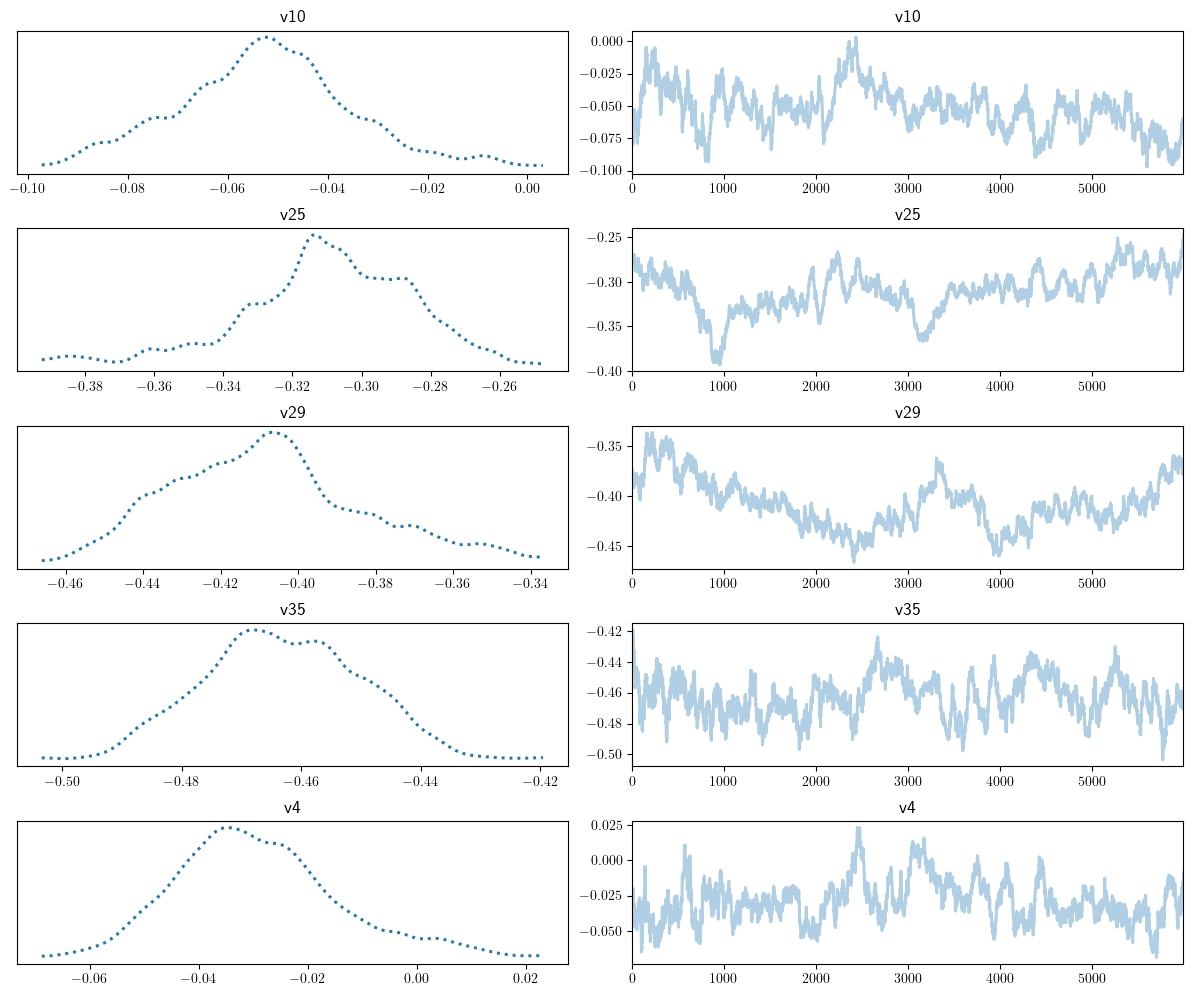

In [56]:
posterior_samples.plot_trace()

[[<matplotlib.lines.Line2D at 0x1a474e2f0>],

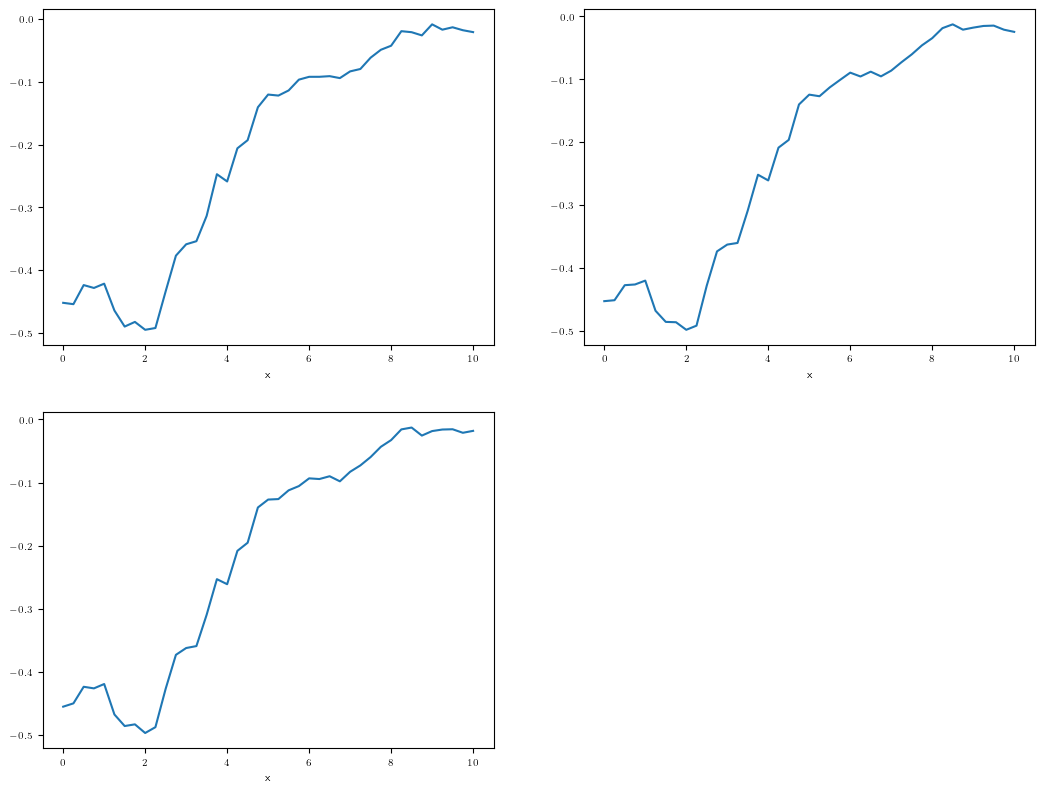

In [57]:
posterior_samples.plot([-1, -3, -5])

Plotting 5 randomly selected samples


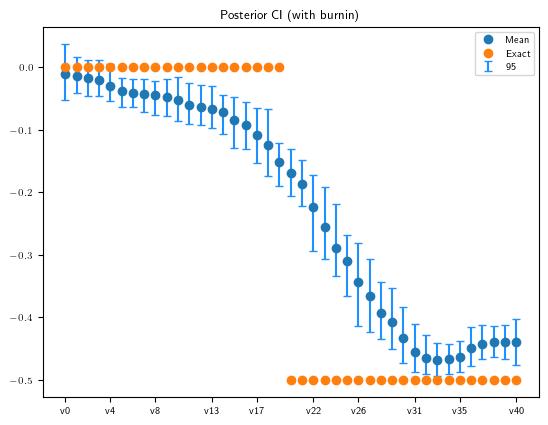

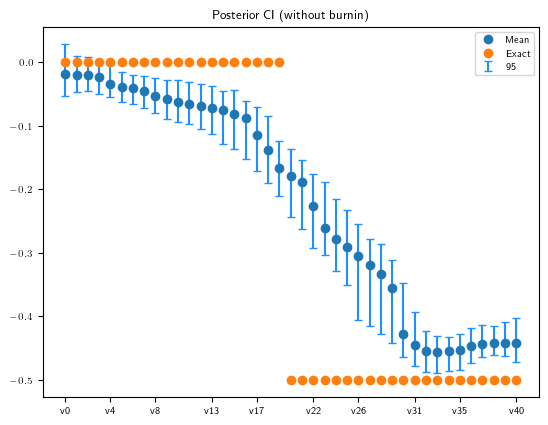

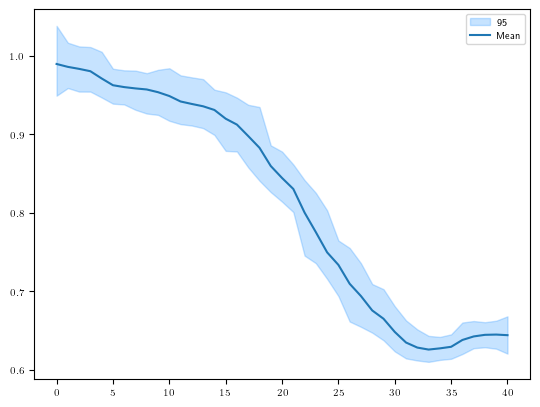

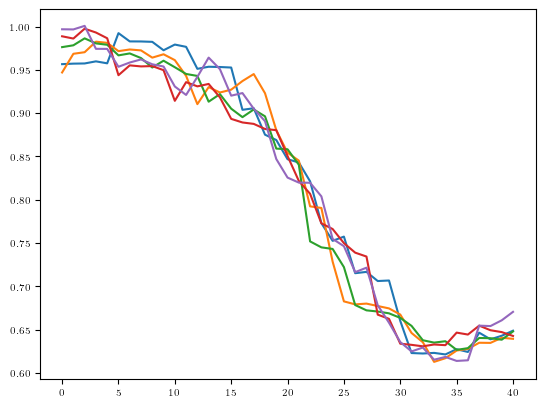

In [58]:


posterior_samples.plot_ci(exact=x_true, plot_par=plot_par)
plt.title('Posterior CI (with burnin)')
plt.figure()
sampler.get_samples().plot_ci(exact=x_true, plot_par=plot_par)
plt.title('Posterior CI (without burnin)')
plt.figure()
mapped_samples = cuqi.samples.Samples( np.exp(posterior_samples.samples))
mapped_samples.plot_ci()
plt.figure()
mapped_samples.plot()

In [59]:
# - [x] 1D case 
# - [ ] DG0
# - [ ] TV with non-MY gradient and with NUTS 
# - [x] verify the gradient of the posterior
# - [x] PCN seems to work (for both 1D and 2D cases)
# - [x] Start from x0=the true parameter to debug

## Verify gradient  (model)

0.042412495347431106


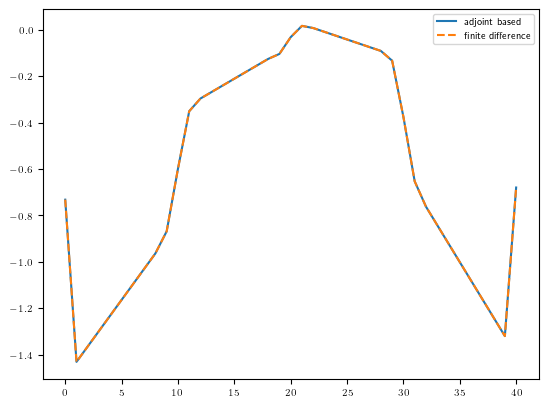

In [60]:


np.random.seed(3)
# random direction y
y0 = np.ones(G_range.par_dim) # np.random.randn(G_range.par_dim)
y0[0] = 0
y0[-1] = 0

# corresponding fenics function
y0_fun = dl.Function(H)
y0_fun.vector()[:] = y0

# objective function
def f(x):
    return A(x).T@ y0.reshape(-1,1)
    #return A(x).vector().get_local().T@ y0.reshape(-1,1)

# objective function gradient
def fprime(x):
    return A.gradient(y0, x)

# random input x (the point which gradient is calculated with respect to)
x0 = np.random.randn(G_domain.par_dim)

# assert that the gradient is correct
print(check_grad(f, fprime, x0))

plt.plot(fprime(x_true))
# plot finite difference gradient 

plt.plot(approx_gradient(f, x_true, 1e-6), '--')
plt.legend(['adjoint based', 'finite difference'])


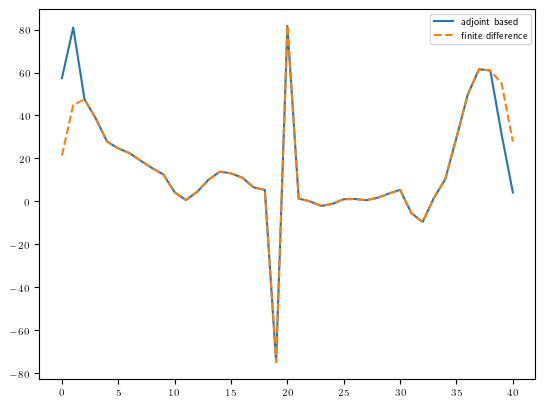

In [61]:
## Verify gradient  (posterior)

plt.plot(posterior.gradient(x_true))
# plot finite difference gradient 

plt.plot(approx_gradient(posterior.logd, x_true, 1e-8), '--')
plt.legend(['adjoint based', 'finite difference'])

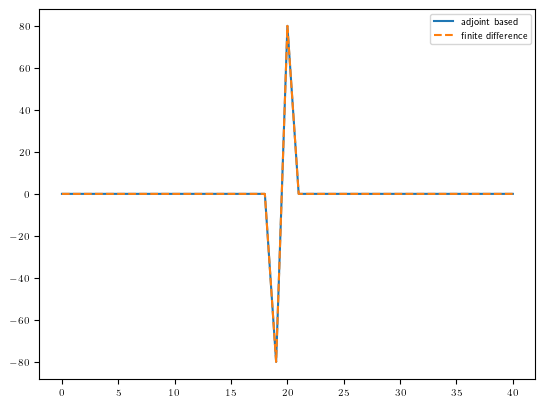

In [62]:
# check the gradient of the prior

plt.plot(x.gradient(x_true))
# plot finite difference gradient 

plt.plot(approx_gradient(x.logd, x_true, 1e-8), '--')
plt.legend(['adjoint based', 'finite difference'])

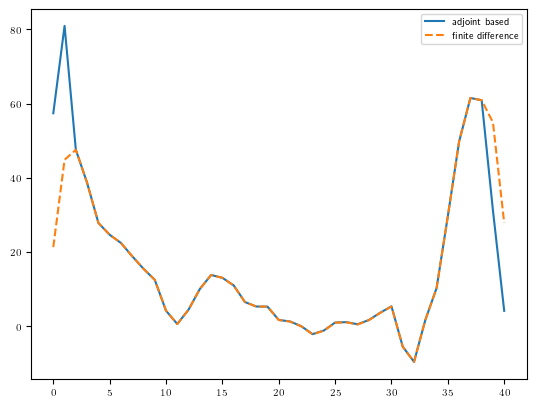

In [63]:
# check the gradient of the likelihood

plt.plot(posterior.likelihood.gradient(x_true))
# plot finite difference gradient 

plt.plot(approx_gradient(posterior.likelihood.logd, x_true, 1e-10), '--')
plt.legend(['adjoint based', 'finite difference'])